In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
import os
import random
import numpy as np
import torch
import torchaudio
from torch.utils.data import Dataset
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

class AudioDataset(Dataset):
    def __init__(self, wav_folder, txt_folder, use_spectrogram=False, 
                 fit_scaler=False, sample_size=None, random_seed=42, 
                 target_length=1024):
        """
        Args:
            wav_folder: Путь к папке с .wav файлами
            txt_folder: Путь к папке с .txt метками
            use_spectrogram: Использовать спектрограммы (иначе FFT)
            fit_scaler: Обучить StandardScaler на метках
            sample_size: Количество случайных файлов для загрузки (None = все)
            random_seed: Seed для воспроизводимости
            target_length: Фиксированная длина для спектрограмм
        """
        self.wav_folder = wav_folder
        self.txt_folder = txt_folder
        self.use_spectrogram = use_spectrogram
        self.target_length = target_length
        self.fit_scaler = fit_scaler
        self.scaler = None

        # Получаем список пар файлов
        all_wavs = sorted([f for f in os.listdir(wav_folder) if f.endswith('.wav')])
        self.file_pairs = []
        
        for wav_file in all_wavs:
            txt_file = wav_file.replace('.wav', '.txt')
            if os.path.exists(os.path.join(txt_folder, txt_file)):
                self.file_pairs.append((wav_file, txt_file))

        # Выбираем подвыборку если нужно
        if sample_size and sample_size < len(self.file_pairs):
            random.seed(random_seed)
            self.file_pairs = random.sample(self.file_pairs, sample_size)

        # Инициализация трансформов
        if use_spectrogram:
            self.spectrogram_transform = torchaudio.transforms.Spectrogram(
                n_fft=1024,
                hop_length=512,
                power=2
            )

        # Обучение scaler если нужно
        if fit_scaler:
            self._fit_scaler()

    def _fit_scaler(self):
        """Предварительная загрузка меток для обучения scaler"""
        all_targets = []
        for _, txt_file in tqdm(self.file_pairs, desc="Fitting scaler"):
            target = np.loadtxt(os.path.join(self.txt_folder, txt_file), dtype=np.float32)
            if len(target) < 44:
                target = np.pad(target, (0, 44 - len(target)), mode='constant')
            all_targets.append(target)
        
        self.scaler = StandardScaler()
        self.scaler.fit(all_targets)

    def _load_and_process(self, wav_path, txt_path):
        """Загрузка и обработка одного файла"""
        # Загрузка аудио
        sample_rate, data = torchaudio.load(wav_path)
        if data.ndim > 1:
            data = data.mean(dim=0)  # Стерео -> моно
        
        # Загрузка метки
        target = np.loadtxt(txt_path, dtype=np.float32)
        if len(target) < 44:
            target = np.pad(target, (0, 44 - len(target)), mode='constant')
        
        # Нормализация метки
        if self.scaler:
            target = self.scaler.transform(target.reshape(1, -1)).squeeze()
        
        # Преобразование в фичи
        if self.use_spectrogram:
            spec = self.spectrogram_transform(data.unsqueeze(0))
            spec = spec.log2().clamp(min=-10)
            spec = (spec - spec.mean()) / (spec.std() + 1e-6)  # Нормализация
            
            # Фиксированная длина
            if spec.shape[2] > self.target_length:
                spec = spec[:, :, :self.target_length]
            else:
                pad = self.target_length - spec.shape[2]
                spec = torch.nn.functional.pad(spec, (0, pad), value=-10)
            
            features = spec.squeeze(0)  # [1, freq, time] -> [freq, time]
        else:
            N = len(data)
            fft_data = torch.fft.fft(torch.from_numpy(data).float())
            fft_magnitude = torch.abs(fft_data[:N//2]) / N
            features = fft_magnitude.unsqueeze(0)  # [1, N//2]
        
        return features, torch.from_numpy(target)

    def __len__(self):
        return len(self.file_pairs)

    def __getitem__(self, idx):
        wav_file, txt_file = self.file_pairs[idx]
        wav_path = os.path.join(self.wav_folder, wav_file)
        txt_path = os.path.join(self.txt_folder, txt_file)
        
        return self._load_and_process(wav_path, txt_path)

модель цнн + трансформер

In [3]:
# === Модель ===
class AudioRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))
        )
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=128, nhead=8, batch_first=True),
            num_layers=3
        )
        self.fc = nn.Linear(128, 44)

    def forward(self, x):
        x = self.cnn(x)     # [B, 128, 1, T]
        x = x.squeeze(2)    # [B, 128, T]
        x = x.permute(0,2,1)  # [B, T, 128] для batch_first
        x = self.transformer(x)
        x = x.mean(dim=1)   # [B, 128]
        out = self.fc(x)
        return out

CNN

In [ ]:
# === Модель ===
class AudioRegressor_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(128, 44)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, 1, H, W)
        x = self.cnn(x)     # [B, 128, 1, T]
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out

In [ ]:
class AudioRegressor_1DCNN(nn.Module):
    def __init__(self, input_length=346858, output_size=44):
        super().__init__()
        
        self.main = nn.Sequential(
            # Блок 1
            nn.Conv1d(1, 32, kernel_size=5, stride=2, padding=2),
            nn.Dropout(0.2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            # Блок 2
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.Dropout(0.2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            # Блок 3
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.Dropout(0.2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        
        # Автоматический расчет размера после сверток
        with torch.no_grad():
            x = torch.randn(1, 1, input_length)
            x = self.main(x)
            flat_size = x.view(1, -1).size(1)
        
        self.fc = nn.Sequential(
            nn.Linear(flat_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, output_size)
        )
    
    def forward(self, x):
        # x shape: [batch, 1, 346858]
        x = self.main(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [ ]:
class CNN2D(nn.Module):
    def __init__(self, output_size):
        super(CNN2D, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        self.fc = nn.Linear(32 * 4 * 4, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, 1, H, W)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        
        # LSTM для каждой частотной компоненты
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=1,
            dropout=0.3
        )
        
        # Полносвязный слой
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x shape: [batch, 1, freq_bins]
        x = x.squeeze(1)  # [batch, freq_bins]
        
        # Обрабатываем каждую частоту отдельно
        batch_size, freq_bins = x.size()
        
        # LSTM
        lstm_out, _ = self.lstm(x)  # [batch, time_steps, hidden_size]
        
        # Объединяем все частотные компоненты
        out = lstm_out.reshape(batch_size, -1)
        
        return self.fc(out)

In [ ]:
# === Константы ===
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-3

WAV_DIR = "data/wav"
TXT_DIR = "data/txt"
print(DEVICE)

In [ ]:
# === Загрузка данных ===
# 1. Создаем общий датасет и подгоняем скейлер
full_dataset = AudioDataset(WAV_DIR, TXT_DIR, fit_scaler=True, sample_size=2000)
scaler = full_dataset.scaler

# 2. Разделяем train/test
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

Loading data:  16%|█▌        | 608/3868 [00:07<00:16, 194.51it/s]c:\Users\Людмила\Documents\samsung project\.venv\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=844
  warnings.warn(
Loading data: 100%|██████████| 3868/3868 [00:48<00:00, 79.08it/s] 


In [6]:
full_dataset.data.shape

(3868, 1, 513, 900)

In [ ]:
sample_x, sample_y = next(iter(train_loader))
print("Input shape:", sample_x.shape)  # Должно быть [batch, channels, freq, time]
print("Target shape:", sample_y.shape)

In [ ]:
# === Обучение ===
# model = LSTMModel(input_size=sample_x.shape[2], hidden_size=256, output_size=sample_y.shape[1])
# model = AudioRegressor_1DCNN(input_length=sample_x.shape[2], output_size=sample_y.shape[1])
model = AudioRegressor()

In [ ]:
# Для ранней остановки
def train(model, train_loader, val_loader, model_name, scaler=None, lr=LEARNING_RATE, EPOCHS=10):
    best_val_loss = float('inf')
    patience = 3
    no_improve = 0
    best_model_weights = None

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()


    train_losses = []
    val_losses = []
    mae_scores = []
    r2_scores = []

    for epoch in range(EPOCHS):
        model.train()
        epoch_train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device).float(), yb.to(device).float()
            preds = model(xb)

            loss = criterion(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)

                loss = criterion(preds, yb)
                val_loss += loss.item()

                all_preds.append(preds.squeeze(1).cpu().numpy())
                all_targets.append(yb.squeeze(1).cpu().numpy())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve = 0
            best_model_weights = model.state_dict().copy()  # Сохраняем веса
            torch.save(model.state_dict(), model_name + '.pth')  # Сохраняем модель
            torch.save(model, model_name + '.pt')  # Сохраняем модель
            print(f"New best model! Val Loss: {val_loss:.4f}")
        else:
            no_improve += 1
            print(f"No improvement for {no_improve}/{patience} epochs")
            if no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_weights)  # Восстанавливаем лучшие веса
                break

        all_preds = np.concatenate(all_preds, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)

        # ДЕНОРМАЛИЗАЦИЯ
        if scaler:
            all_preds = scaler.inverse_transform(all_preds)
            all_targets = scaler.inverse_transform(all_targets)

        mae = mean_absolute_error(all_targets, all_preds)
        r2 = r2_score(all_targets, all_preds)

        mae_scores.append(mae)
        r2_scores.append(r2)

        print(f"[Epoch {epoch+1}] Train Loss: {epoch_train_loss:.4f} | Val Loss: {val_loss:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

    with open(model_name + '_architecture.json', 'w') as f:
        f.write(str(model))
        
    return train_losses, val_losses, mae_scores, r2_scores

New best model! Val Loss: 1.0590
[Epoch 1] Train Loss: 0.6333 | Val Loss: 1.0590 | MAE: 111.6221 | R²: 0.2867
No improvement for 1/3 epochs
[Epoch 2] Train Loss: 0.6002 | Val Loss: 1.2930 | MAE: 1324.0298 | R²: -0.0018
New best model! Val Loss: 1.0503
[Epoch 3] Train Loss: 0.6998 | Val Loss: 1.0503 | MAE: 275.8149 | R²: 0.2949
No improvement for 1/3 epochs
[Epoch 4] Train Loss: 0.6519 | Val Loss: 1.2943 | MAE: 635.4542 | R²: 0.0627
New best model! Val Loss: 1.0396
[Epoch 5] Train Loss: 0.6417 | Val Loss: 1.0396 | MAE: 136.6718 | R²: 0.3333
No improvement for 1/3 epochs
[Epoch 6] Train Loss: 0.5601 | Val Loss: 1.0447 | MAE: 263.8145 | R²: 0.3321
No improvement for 2/3 epochs
[Epoch 7] Train Loss: 0.5595 | Val Loss: 1.0421 | MAE: 937.3510 | R²: 0.1318
No improvement for 3/3 epochs
Early stopping at epoch 8


In [ ]:
train_losses, val_losses, mae_scores, r2_scores = train(model, train_loader, val_loader, 'CNNTransformerScaler')

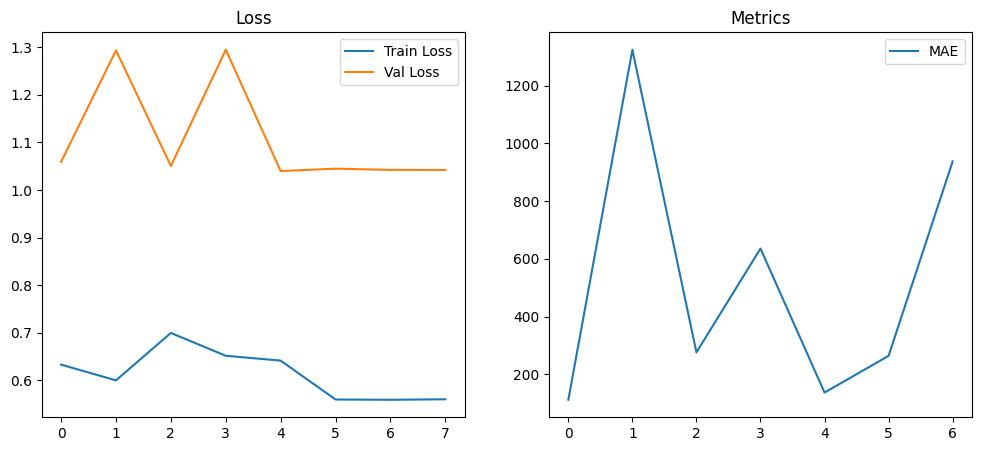

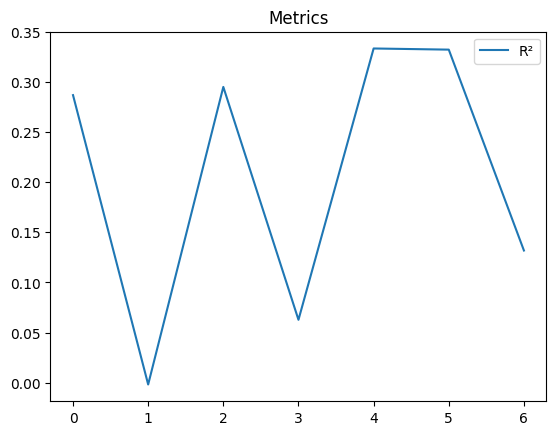

In [9]:
# === Графики ===
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(mae_scores, label='MAE')
plt.legend()
plt.title("Metrics")
plt.show()


plt.plot(r2_scores, label='R²')
plt.legend()
plt.title("Metrics")
plt.show()